In [1]:
import numpy as np
import jax.numpy as jnp
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
from jax import jacfwd

In [2]:
# def measurement(v1, v2):
#     rg = jnp.linalg.norm(v1 - v2)
#     br = (v2[1] - v1[1]) / rg + (v2[0] - v1[0]) / rg
#     return jnp.array([rg, br])

def measurement(v1, v2):
    return v2 - v1 

# def measurement(v1, v2):
#     return v2 ** 2 - v1 

print('test measurement: ', measurement(np.array([0.,0.]), np.array([1.,2.])))

test measurement:  [1. 2.]


In [3]:
measurement_jac_v1 = jacfwd(measurement, argnums=0)
measurement_jac_v2 = jacfwd(measurement, argnums=1)
print('test measurement jacobian:')
print(measurement_jac_v1(np.array([0.,0.]), np.array([1.,2.])))
print(measurement_jac_v2(np.array([0.,0.]), np.array([1.,2.])))

test measurement jacobian:
[[-1. -0.]
 [-0. -1.]]
[[1. 0.]
 [0. 1.]]


In [4]:
nodes_gt = np.array([
    [0., 0.],
    [1., 0.],
    [2., 0.],
    [1., 1.],
    [2., 1.],
])

In [5]:
import time
np.random.seed(int(time.time()*1000) % 1000)
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.2, 0.2]), size=5)
noise = np.clip(noise, a_min=-0.3, a_max=0.3)
nodes_ns = nodes_gt + noise

In [6]:
edges = np.array([
    [0, 1],
    [0, 3],
    [1, 3],
    [1, 2],
    [2, 4]
], dtype=int)

In [7]:
def config_figure(title=None):
    fig, ax = plt.subplots(1, 1, figsize=(8., 6.))
    ax.set_aspect('equal')
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 1.5)
    if title is not None:
        ax.set_title(title, fontsize=15)
    return fig, ax

In [8]:
def plot_graph(nodes, edges, title=None):
    fig, ax = config_figure(title)
    
    for edge in edges:
        n1 = nodes[edge[0]]
        n2 = nodes[edge[1]]
        ax.plot([n1[0], n2[0]], [n1[1], n2[1]], color='C1', linewidth=5)
    for i in range(nodes.shape[0]):
        node = nodes[i]
        ax.plot(node[0], node[1], c='C0', linestyle='', marker='o', markersize=20)
        ax.text(node[0]+0.05, node[1]-0.12, 'node{}'.format(i), fontsize=12, fontweight='heavy', color='C0')
    
    plt.show()

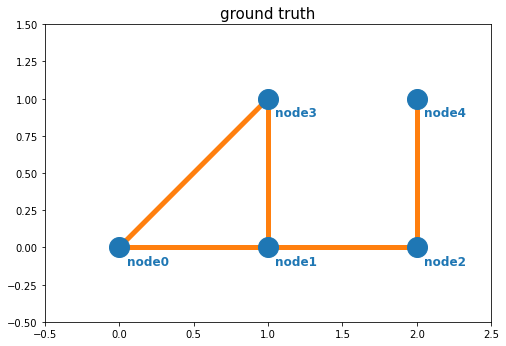

In [9]:
plot_graph(nodes_gt, edges, 'ground truth')

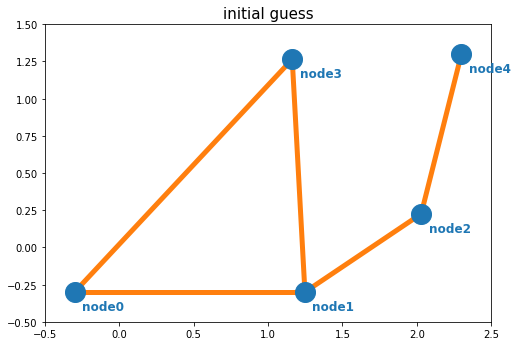

In [10]:
plot_graph(nodes_ns, edges, 'initial guess')

In [11]:
obsv_gt = np.array([
    measurement(nodes_gt[edge[0]], nodes_gt[edge[1]])
    for edge in edges
])
obsv_gt

array([[1., 0.],
       [1., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [12]:
noise = mvn.rvs(mean=np.zeros(2), cov=np.diag([0.001, 0.001]), size=5)
noise = np.clip(noise, a_min=-0.05, a_max=0.05)
obsv_ns = obsv_gt + noise
obsv_ns[:,1] = np.clip(obsv_ns[:,1], a_min=-1., a_max=1.)
obsv_ns

array([[ 0.98335639,  0.00371268],
       [ 0.97911088,  1.        ],
       [-0.04497521,  0.95      ],
       [ 0.97338303, -0.01755529],
       [ 0.03407194,  0.96463253]])

In [13]:
def binary_factor(v1, v2, obsv):
    sim_obsv = np.array(measurement(v1, v2))
    diff = sim_obsv - obsv
    return (diff[0]**2 + diff[1]**2) #/ 0.01

binary_factor(nodes_gt[0], nodes_gt[1], obsv_ns[0])

0.0002907937514892199

In [14]:
def objective(nodes, edges, obsv_list):
    obj = 0.
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        obj += binary_factor(v1, v2, obsv) / 2
    return obj
    
objective(nodes_gt, edges, obsv_ns)

0.004339162651141797

In [15]:
def objective_jac(nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        obsv = obsv_list[i]
        diff = measurement(v1, v2) - obsv
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2) 
        jac[ed[0]] += jac_v1 @ diff
        jac[ed[1]] += jac_v2 @ diff
    return jac

In [16]:
objective_jac(nodes_gt, edges, obsv_ns)

array([[-0.03753273,  0.00371268],
       [-0.05494858, -0.07126798],
       [ 0.06068892, -0.01781218],
       [ 0.06586433,  0.05      ],
       [-0.03407194,  0.03536747]])

In [17]:
def fg_armijo(x, p, f, df):
    c = 1e-04
    a = 1.0
    rho = 0.5
    for i in range(10):
        df_sum = 0.
        df_k = df(x)
        for j in range(p.shape[0]):
            df_sum += p[j][0]*df_k[j][0] + p[j][1]*df_k[j][1]
        gap = f(x + a*p) - f(x) - c*a*df_sum
        #print('armijo {} gap: {}'.format(i, gap))
        if gap < 0.:
            return a
        else:
            a *= rho
    return 0.0

In [18]:
nodes_p = objective_jac(nodes_gt, edges, obsv_ns)
step_len = fg_armijo(nodes_gt, -nodes_p, 
                     lambda nodes: objective(nodes, edges, obsv_ns), 
                     lambda nodes: objective_jac(nodes, edges, obsv_ns))

In [19]:
def fg_gradient_descent(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        nodes_p = objective_jac(nodes_k, edges, obsv_list)
        nodes_p_norm = np.linalg.norm(nodes_p)
        
#         if(nodes_p_norm < 1e-06):
#             print('converged.')
#             break
        
        step_len = fg_armijo(nodes_k, -nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k -= nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.8251040990758446, 0.3101554433313637
iteration 1: 0.5149486557444809, 0.02814464311033177
iteration 2: 0.48680401263414913, 0.4721280317437873
iteration 3: 0.014675980890361819, 0.006347059732576049
iteration 4: 0.00832892115778577, 0.0030083420906451917
iteration 5: 0.0053205790671405784, 0.0014490620565006198
iteration 6: 0.0038715170106399586, 0.0006469133560946488
iteration 7: 0.00322460365454531, 0.00020290237358195056
iteration 8: 0.0030217012809633592, 0.001951267826586376
iteration 9: 0.0010704334543769833, 0.0003031108678970074
iteration 10: 0.0007673225864799759, 3.978698654884044e-05
converged.


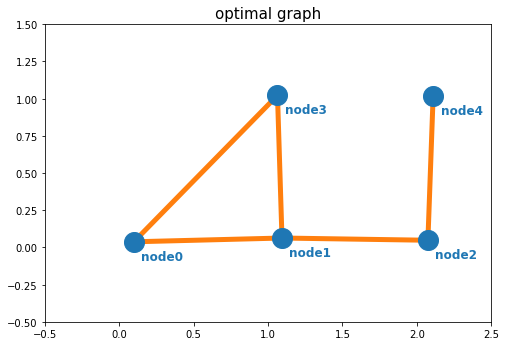

In [20]:
nodes_opt = fg_gradient_descent(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt, edges, 'optimal graph')

In [21]:
def linearized_objective_jac(increments, nodes, edges, obsv_list):
    jac = np.zeros_like(nodes)
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        c = measurement(v1, v2) - obsv
        diff1 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        diff2 = jac_v1 @ icrmt1 + jac_v2 @ icrmt2 + c
        
        jac[ed[0]] += jac_v1 @ diff1
        jac[ed[1]] += jac_v2 @ diff2
        
    return jac

In [22]:
increments_test = np.ones_like(nodes_gt) * 0.0
print(objective_jac(nodes_ns, edges, obsv_ns), end='\n\n')
print(linearized_objective_jac(increments_test, nodes_ns, edges, obsv_ns))

[[-1.04818571 -0.56073004]
 [ 0.79706848 -1.16111028]
 [-0.42874822  0.43298709]
 [ 0.44321191  1.17888542]
 [ 0.23665356  0.10996783]]

[[-1.04818571 -0.56073004]
 [ 0.79706848 -1.16111028]
 [-0.42874822  0.43298709]
 [ 0.44321191  1.17888546]
 [ 0.23665357  0.10996783]]


In [23]:
def linearized_objective_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return np.linalg.norm(J @ increments.ravel() - y) ** 2 / 2

In [24]:
increments_test = np.random.normal(size=nodes_ns.shape) * 0.01
print(linearized_objective_fullmatrix(increments_test, nodes_ns, edges, obsv_ns))
print(objective(nodes_ns+increments_test, edges, obsv_ns))

0.7785213144133425
0.8762806788593609


In [25]:
def linearized_objective_jac_fullmatrix(increments, nodes, edges, obsv_list):
    J = np.zeros((obsv_list.ravel().shape[0], nodes.ravel().shape[0]))
    y = np.zeros(obsv_list.ravel().shape[0])
    
    for i in range(edges.shape[0]):
        ed = edges[i]
        v1 = nodes[ed[0]]
        v2 = nodes[ed[1]]
        icrmt1 = increments[ed[0]]
        icrmt2 = increments[ed[1]]
        obsv = obsv_list[i]
        
        diff = measurement(v1, v2) - obsv
        y[i*2 : i*2+2] = diff
        
        jac_v1 = measurement_jac_v1(v1, v2)
        jac_v2 = measurement_jac_v2(v1, v2)
        J[i*2][ed[0]*2 : ed[0]*2+2] = jac_v1[:,0]
        J[i*2][ed[1]*2 : ed[1]*2+2] = jac_v2[:,0]
        J[i*2+1][ed[0]*2 : ed[0]*2+2] = jac_v1[:,1]
        J[i*2+1][ed[1]*2 : ed[1]*2+2] = jac_v2[:,1]
    
    return J, y, J.T @ (J @ increments.ravel() + y)

[[-1.0481857  -0.56073003]
 [ 0.79706844 -1.16111033]
 [-0.42874822  0.43298711]
 [ 0.44321191  1.17888542]
 [ 0.23665356  0.10996783]]


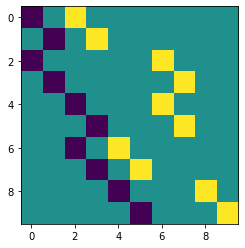

In [26]:
increments_test = np.ones_like(nodes_gt) * 0.0
J, y, obj_jac = linearized_objective_jac_fullmatrix(increments_test, nodes_ns, edges, obsv_ns)
print(obj_jac.reshape(-1,2))
plt.imshow(J)

In [27]:
def fg_gauss_newton(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, obj_jac = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.8251040990758446, 0.8244705284124146
iteration 1: 0.000633570663429947, 8.673617379884035e-19
converged.


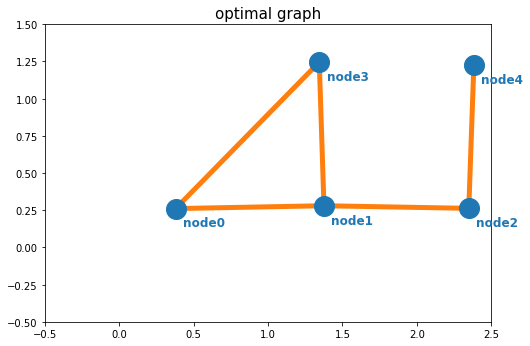

In [28]:
nodes_opt_gn = fg_gauss_newton(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

In [29]:
def back_substitute(A, b): # A is square upper-triangular
    x = np.zeros_like(b)
    for i in range(x.shape[0]):
        curr_row = x.shape[0] - i - 1
        val = b[curr_row]
        #print(val)
        for j in range(i):
            prev_col = x.shape[0] - j - 1
            val -= x[prev_col] * A[curr_row, prev_col]
            #print(j, val)
        #print(val, A[curr_row, curr_row], val / A[curr_row, curr_row])
        if A[curr_row, curr_row] == 0.:
            x[curr_row] = 0.
        else:
            x[curr_row] = val / A[curr_row, curr_row]
    return x

In [30]:
A_test = np.array([[2, -4, 6], [0, 2, -2], [0, 0, 3]], dtype=float)
b_test = np.array([8, 1, 9], dtype=float)
x_test = back_substitute(A_test, b_test)
print(x_test)

[2.  3.5 3. ]


In [31]:
def fg_gauss_newton_qr(nodes, edges, obsv_list):
    nodes_k = nodes.copy()
    for i in range(50):
        obj_k = objective(nodes_k, edges, obsv_list)
        
        J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_k), nodes_k, edges, obsv_list)
        
        Q, R = np.linalg.qr(J, 'reduced')
        nodes_p = back_substitute(R, -Q.T@y)
        
        #nodes_p = np.linalg.inv(J.T @ J) @ (-J.T @ y)
        #nodes_p = np.linalg.solve(J.T @ J, -J.T @ y) # more stable
        nodes_p = np.array(nodes_p).reshape(-1,2)
        
        nodes_p_norm = np.linalg.norm(nodes_p)
        
        step_len = fg_armijo(nodes_k, nodes_p, 
                             lambda nodes: objective(nodes, edges, obsv_list), 
                             lambda nodes: objective_jac(nodes, edges, obsv_list))
        
        nodes_k += nodes_p * step_len
        obj_knew = objective(nodes_k, edges, obsv_list)
        
        drop = obj_k - obj_knew
        print('iteration {}: {}, {}'.format(i, obj_k, drop))
        if drop < 1e-04:
            print('converged.')
            break
        
    return nodes_k

iteration 0: 0.8251040990758446, 0.8244705284124146
iteration 1: 0.000633570663429947, 8.673617379884035e-19
converged.


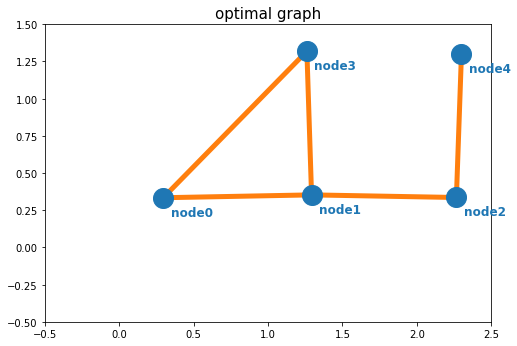

In [32]:
nodes_opt_gn = fg_gauss_newton_qr(nodes_ns, edges, obsv_ns)
plot_graph(nodes_opt_gn, edges, 'optimal graph')

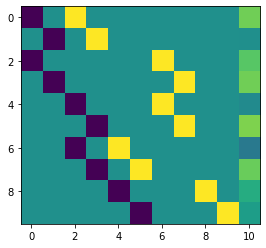

In [33]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
plt.imshow(np.concatenate((J, y[:,np.newaxis]), axis=1))

In [62]:
def variable_elimination(J_, y_):
    J = J_.copy()
    y = y_.copy()
    full_mat = np.concatenate((J, y[:,np.newaxis]), axis=1)
    
    for i in range(J.shape[1]): # number of states
        plt.imshow(J)
        plt.show()
        
        separator = []
        rows = []
        for j in range(J.shape[0]):
            row = J[j]
            if row[i] != 0:
                rows.append(j)
                for k in range(row.shape[0]):
                    if row[k] != 0. and i != k:
                        separator.append(k)
        print('node: ', i)
        print('separator: ', separator, ' , rows: ', rows)
        
        separator_with_node = np.sort([i] + separator)
        print('separator with node: ', separator_with_node)
        
        a = J[rows, i]
        As = J[rows][:, separator]
        b = -y[rows]
        
        ainv = a / (a.T @ a)
        r = ainv @ As
        d = ainv @ b
        Ap_temp = As - np.outer(a, r)
        Ap = np.concatenate((np.zeros((Ap_temp.shape[0], 1)), Ap_temp), axis=1)
        Ap[0][0] = 1
        bp = b - a * d
        
        print(Ap)
        
        for j in range(len(rows)):
            row = rows[j]
            J[row][separator_with_node] = Ap[j]
#             print(J[row][separator_with_node])
#             print(Ap[j])
        y[rows] = bp
        
    return J, y

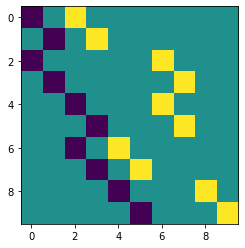

node:  0
separator:  [2, 6]  , rows:  [0, 2]
separator with node:  [0 2 6]
[[ 1.   0.5 -0.5]
 [ 0.  -0.5  0.5]]


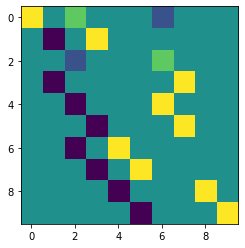

node:  1
separator:  [3, 7]  , rows:  [1, 3]
separator with node:  [1 3 7]
[[ 1.   0.5 -0.5]
 [ 0.  -0.5  0.5]]


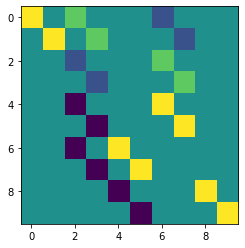

node:  2
separator:  [0, 6, 6, 6, 4]  , rows:  [0, 2, 4, 6]
separator with node:  [0 2 4 6 6 6]
[[ 1.   0.9 -0.2 -0.2 -0.2  0.2]
 [ 0.   0.1  0.2  0.2  0.2 -0.2]
 [ 0.   0.2  0.4  0.4  0.4 -0.4]
 [ 0.   0.2 -0.6 -0.6 -0.6  0.6]]


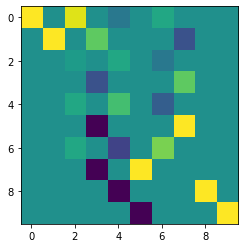

node:  3
separator:  [1, 7, 7, 7, 5]  , rows:  [1, 3, 5, 7]
separator with node:  [1 3 5 7 7 7]
[[ 1.   0.9 -0.2 -0.2 -0.2  0.2]
 [ 0.   0.1  0.2  0.2  0.2 -0.2]
 [ 0.   0.2  0.4  0.4  0.4 -0.4]
 [ 0.   0.2 -0.6 -0.6 -0.6  0.6]]


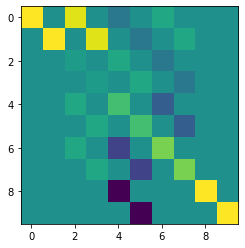

node:  4
separator:  [0, 2, 6, 2, 6, 2, 6, 2, 6, 8]  , rows:  [0, 2, 4, 6, 8]
separator with node:  [0 2 2 2 2 4 6 6 6 6 8]
[[ 1.     0.975  0.875  0.125  0.875  0.125  0.875  0.125  0.875  0.125
  -0.125]
 [ 0.     0.025  0.125 -0.125  0.125 -0.125  0.125 -0.125  0.125 -0.125
   0.125]
 [ 0.     0.05   0.25  -0.25   0.25  -0.25   0.25  -0.25   0.25  -0.25
   0.25 ]
 [ 0.    -0.075  0.125  0.375  0.125  0.375  0.125  0.375  0.125  0.375
  -0.375]
 [ 0.    -0.125 -0.125 -0.375 -0.125 -0.375 -0.125 -0.375 -0.125 -0.375
   0.375]]


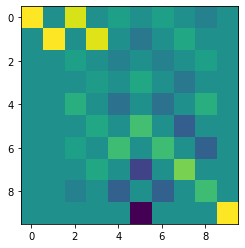

node:  5
separator:  [1, 3, 7, 3, 7, 3, 7, 3, 7, 9]  , rows:  [1, 3, 5, 7, 9]
separator with node:  [1 3 3 3 3 5 7 7 7 7 9]
[[ 1.     0.975  0.875  0.125  0.875  0.125  0.875  0.125  0.875  0.125
  -0.125]
 [ 0.     0.025  0.125 -0.125  0.125 -0.125  0.125 -0.125  0.125 -0.125
   0.125]
 [ 0.     0.05   0.25  -0.25   0.25  -0.25   0.25  -0.25   0.25  -0.25
   0.25 ]
 [ 0.    -0.075  0.125  0.375  0.125  0.375  0.125  0.375  0.125  0.375
  -0.375]
 [ 0.    -0.125 -0.125 -0.375 -0.125 -0.375 -0.125 -0.375 -0.125 -0.375
   0.375]]


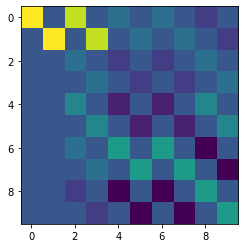

node:  6
separator:  [0, 2, 4, 8, 2, 4, 8, 2, 4, 8, 2, 4, 8, 2, 4, 8]  , rows:  [0, 2, 4, 6, 8]
separator with node:  [0 2 2 2 2 2 4 4 4 4 4 6 8 8 8 8 8]
[[ 1.00000000e+00  9.58333333e-01  8.33333333e-01  1.38777878e-17
   0.00000000e+00  8.33333333e-01  1.38777878e-17  0.00000000e+00
   8.33333333e-01  1.38777878e-17  0.00000000e+00  8.33333333e-01
   1.38777878e-17  0.00000000e+00  8.33333333e-01  1.38777878e-17
   0.00000000e+00]
 [ 0.00000000e+00  4.16666667e-02  1.66666667e-01 -1.38777878e-17
   0.00000000e+00  1.66666667e-01 -1.38777878e-17  0.00000000e+00
   1.66666667e-01 -1.38777878e-17  0.00000000e+00  1.66666667e-01
  -1.38777878e-17  0.00000000e+00  1.66666667e-01 -1.38777878e-17
   0.00000000e+00]
 [ 0.00000000e+00  8.33333333e-02  3.33333333e-01 -2.77555756e-17
   0.00000000e+00  3.33333333e-01 -2.77555756e-17  0.00000000e+00
   3.33333333e-01 -2.77555756e-17  0.00000000e+00  3.33333333e-01
  -2.77555756e-17  0.00000000e+00  3.33333333e-01 -2.77555756e-17
   0.00000000e+0

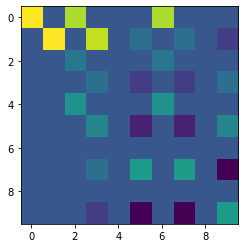

node:  7
separator:  [1, 3, 5, 9, 3, 5, 9, 3, 5, 9, 3, 5, 9, 3, 5, 9]  , rows:  [1, 3, 5, 7, 9]
separator with node:  [1 3 3 3 3 3 5 5 5 5 5 7 9 9 9 9 9]
[[ 1.00000000e+00  9.58333333e-01  8.33333333e-01  1.38777878e-17
   0.00000000e+00  8.33333333e-01  1.38777878e-17  0.00000000e+00
   8.33333333e-01  1.38777878e-17  0.00000000e+00  8.33333333e-01
   1.38777878e-17  0.00000000e+00  8.33333333e-01  1.38777878e-17
   0.00000000e+00]
 [ 0.00000000e+00  4.16666667e-02  1.66666667e-01 -1.38777878e-17
   0.00000000e+00  1.66666667e-01 -1.38777878e-17  0.00000000e+00
   1.66666667e-01 -1.38777878e-17  0.00000000e+00  1.66666667e-01
  -1.38777878e-17  0.00000000e+00  1.66666667e-01 -1.38777878e-17
   0.00000000e+00]
 [ 0.00000000e+00  8.33333333e-02  3.33333333e-01 -2.77555756e-17
   0.00000000e+00  3.33333333e-01 -2.77555756e-17  0.00000000e+00
   3.33333333e-01 -2.77555756e-17  0.00000000e+00  3.33333333e-01
  -2.77555756e-17  0.00000000e+00  3.33333333e-01 -2.77555756e-17
   0.00000000e+0

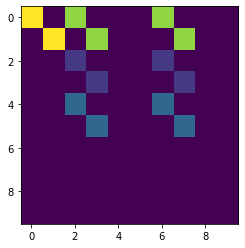

node:  8
separator:  [2, 4, 6]  , rows:  [8]
separator with node:  [2 4 6 8]
[[1. 0. 0. 0.]]


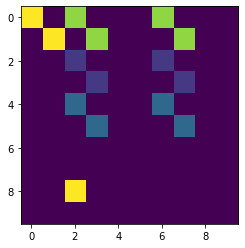

node:  9
separator:  [3, 5, 7]  , rows:  [9]
separator with node:  [3 5 7 9]
[[1. 0. 0. 0.]]


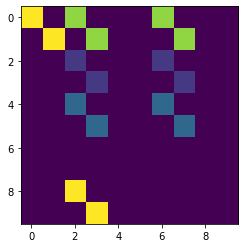

In [63]:
J, y, _ = linearized_objective_jac_fullmatrix(np.zeros_like(nodes_ns), nodes_ns, edges, obsv_ns)
J, y = variable_elimination(J, y)
plt.imshow(J)